In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from collections import defaultdict
from datetime import datetime

# Define the Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 1000  # Number of episodes for training

# Fetch stock data using yfinance
data = yf.download("AAPL", start="2020-01-01", end=datetime.today().strftime('%Y-%m-%d'))

[*********************100%%**********************]  1 of 1 completed


In [6]:
# We will use the 'Close' price for our predictions
data = data['Close']
# Normalize the data
data_norm = (data - data.min()) / (data.max() - data.min())
# Convert to a list for easier manipulation
price_list = data_norm.tolist()
# Define the Q-table
Q = defaultdict(lambda: np.zeros(2))  # Two actions: Buy (0) or Sell (1)

In [7]:
# Helper function to get state from price
def get_state(price_index):
    return price_index


# Train the Q-learning agent
for episode in range(num_episodes):
    state = 0  # Start at the beginning of the price list
    while state < len(price_list) - 1:
        # Choose an action
        if np.random.rand() < epsilon:
            action = np.random.choice([0, 1])  # Explore: random action
        else:
            # Exploit: action with highest Q value
            action = np.argmax(Q[state])

        # Take action and move to next state
        next_state = state + 1
        reward = price_list[next_state] - \
            price_list[state] if action == 0 else price_list[state] - \
            price_list[next_state]

        # Update Q-value
        best_next_action = np.argmax(Q[next_state])
        Q[state][action] = Q[state][action] + alpha * \
            (reward + gamma * Q[next_state]
             [best_next_action] - Q[state][action])

        state = next_state

# Create a list to hold predicted prices
predicted_prices = [price_list[0]]  # Start with the first actual price

# Generate predicted prices using the trained Q-table
state = 0
for _ in range(len(price_list) - 1):
    action = np.argmax(Q[state])  # Choose the best action based on Q values
    if action == 0:
        # Simulate buying and price going up
        predicted_prices.append(price_list[state] + 0.01)
    else:
        # Simulate selling and price going down
        predicted_prices.append(price_list[state] - 0.01)
    state += 1

In [8]:
# Extend predictions for the next 30 steps
for _ in range(30):
    action = np.argmax(Q[state])  # Choose the best action based on Q values
    if action == 0:
        predicted_prices.append(predicted_prices[-1] + 0.01)
    else:
        predicted_prices.append(predicted_prices[-1] - 0.01)
    state += 1

# Convert predicted prices back to the original scale
predicted_prices_rescaled = [price * (data.max() - data.min()) + data.min() for price in predicted_prices]

# Separate training and future predictions
predicted_training_prices = predicted_prices_rescaled[:len(data)]
predicted_future_prices = predicted_prices_rescaled[len(data):]

# Create a DataFrame for the predicted future dates
predicted_dates = pd.date_range(start=data.index[-1], periods=31, freq='B')[1:]  #

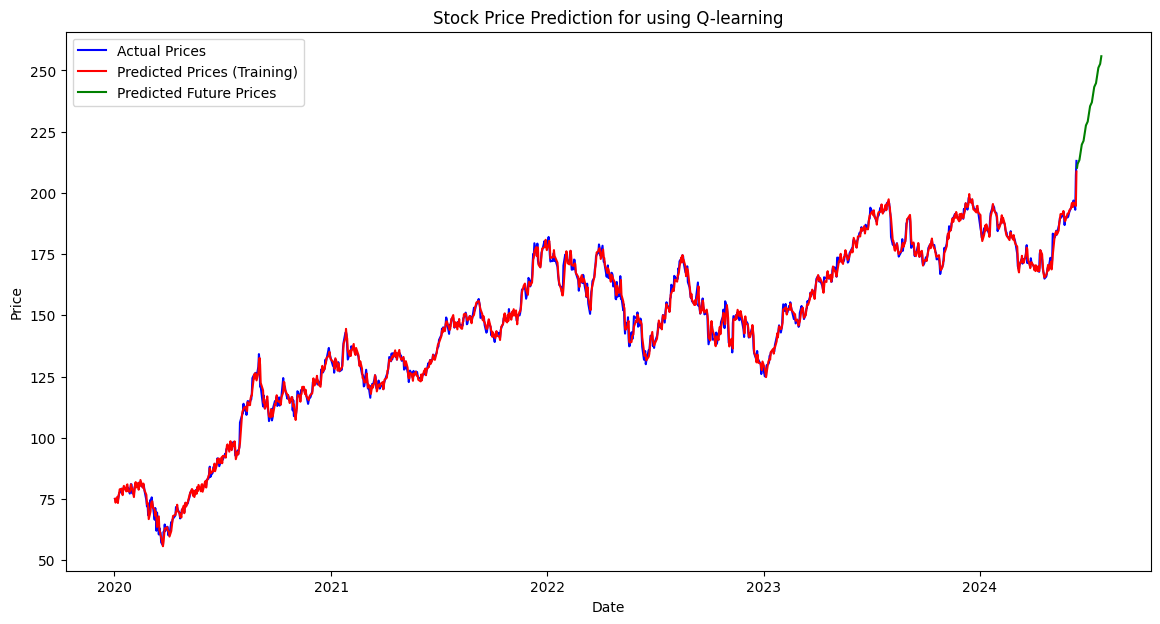

In [9]:
# Plot the actual and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(data.index, data, label='Actual Prices', color='blue')
plt.plot(data.index, predicted_training_prices, label='Predicted Prices (Training)', color='red')
plt.plot(predicted_dates, predicted_prices_rescaled[len(data):], label='Predicted Future Prices', color='green')
plt.title(f"Stock Price Prediction for using Q-learning")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_prices = data[-30:]  # Last 30 actual prices in the dataset
predicted_last_30 = predicted_prices_rescaled[len(data)-30:len(data)]

mae = mean_absolute_error(actual_prices, predicted_last_30)
mse = mean_squared_error(actual_prices, predicted_last_30)

print(f"Mean Absolute Error (MAE) for the last 30 days: {mae:.4f}")
print(f"Mean Squared Error (MSE) for the last 30 days: {mse:.4f}")

Mean Absolute Error (MAE) for the last 30 days: 1.6700
Mean Squared Error (MSE) for the last 30 days: 9.5680


Deep Q-Learning

[*********************100%%**********************]  1 of 1 completed


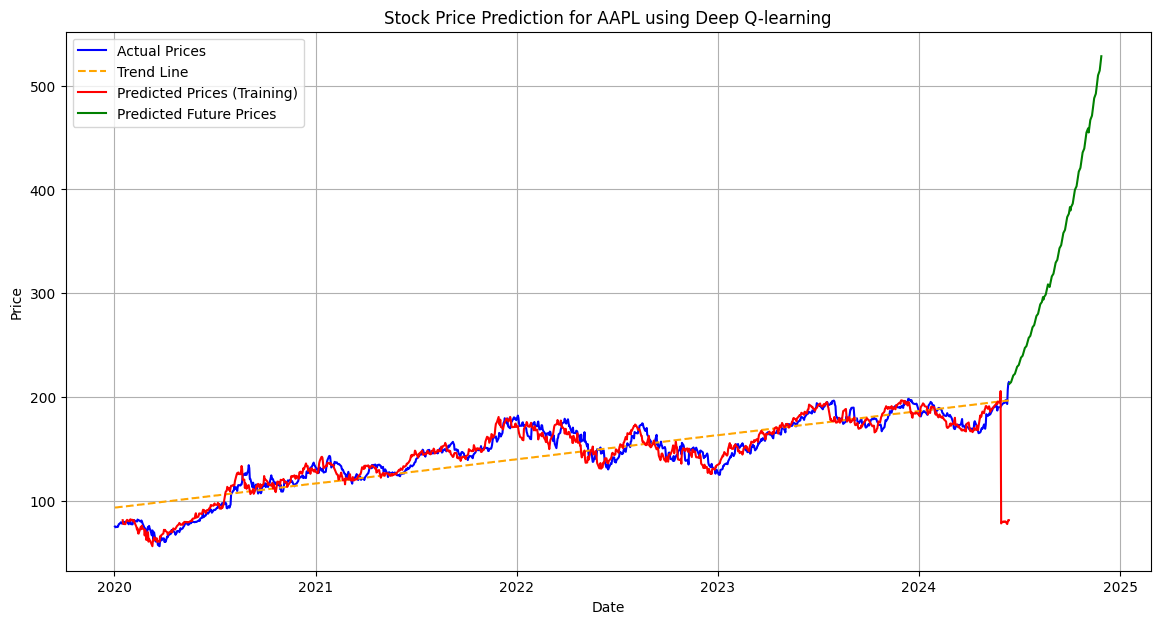

Mean Absolute Error (MAE) for the last 30 days: 179.8899
Mean Squared Error (MSE) for the last 30 days: 32507.3606


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from sklearn.linear_model import LinearRegression

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Function to normalize stock prices
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

# Experience replay memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Select action based on epsilon-greedy policy
def select_action(state, epsilon, model, num_actions):
    if np.random.rand() < epsilon:
        return np.random.randint(num_actions)
    else:
        with torch.no_grad():
            return model(state).argmax().item()


# Function to compute the reward based on deviation from the linear trend
def compute_reward(predicted_price, actual_price, trend_price):
    # Smaller deviation from trend is better
    return -abs(predicted_price - trend_price)

# Deep Q-Learning function for future price prediction


def deep_q_learning(stock_ticker, start_date, end_date, future_steps=120, num_episodes=1500, epsilon=0.1, gamma=0.99, batch_size=64):
    # Fetch stock data using yfinance
    data = yf.download(stock_ticker, start=start_date, end=end_date)

    if data.empty:
        print(f"No data fetched for {stock_ticker} from {
              start_date} to {end_date}.")
        return

    data = data['Close']
    data_norm = normalize(data)
    price_list = data_norm.tolist()

    if len(price_list) < 5:
        print(f"Not enough data points for {stock_ticker} to train the model.")
        return

    # Fit a linear regression model to the historical prices
    x = np.arange(len(data)).reshape(-1, 1)
    y = data.values
    lin_reg = LinearRegression().fit(x, y)
    trend_prices = lin_reg.predict(x)

    # Normalize the trend prices to match the normalized data
    trend_prices_norm = normalize(
        pd.Series(trend_prices, index=data.index)).tolist()

    # Define environment
    num_states = 10  # Number of recent prices to define the state
    num_actions = 2  # Predict next price going up (1) or down (0)

    # Initialize the DQN model and optimizer
    model = DQN(input_dim=num_states, output_dim=num_actions)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    loss_fn = nn.MSELoss()

    # Replay memory
    memory = ReplayMemory(3000)  # Memory capacity

    # Track predicted prices during training for plotting
    predicted_training_prices = []

    # Train the model
    for episode in range(num_episodes):
        state = torch.tensor(
            price_list[:num_states], dtype=torch.float32).unsqueeze(0)
        for t in range(num_states, len(price_list) - 1):
            action = select_action(state, epsilon, model, num_actions)
            next_state = torch.tensor(
                price_list[t - num_states + 1:t + 1], dtype=torch.float32).unsqueeze(0)

            # Predict the next price based on action
            if action == 0:  # Predict price will decrease
                predicted_price = state.squeeze().numpy(
                )[-1] * (1 - 0.01)  # Simulate a 1% decrease
            else:  # Predict price will increase
                predicted_price = state.squeeze().numpy(
                )[-1] * (1 + 0.01)  # Simulate a 1% increase

            actual_price = price_list[t + 1]
            trend_price = trend_prices_norm[t + 1]
            reward = compute_reward(predicted_price, actual_price, trend_price)

            # Store the experience
            memory.push((state, action, reward, next_state))

            # Track the predicted price
            predicted_training_prices.append(predicted_price)

            # Move to the next state
            state = next_state

            # Sample a random batch from memory
            if len(memory) >= batch_size:
                batch = memory.sample(batch_size)
                batch_states, batch_actions, batch_rewards, batch_next_states = zip(
                    *batch)

                batch_states = torch.cat(batch_states)
                batch_actions = torch.tensor(batch_actions)
                batch_rewards = torch.tensor(
                    batch_rewards, dtype=torch.float32)
                batch_next_states = torch.cat(batch_next_states)

                # Compute Q(s, a) and max Q(s', a') using the model
                current_q_values = model(batch_states).gather(
                    1, batch_actions.unsqueeze(1)).squeeze()
                next_q_values = model(batch_next_states).max(1)[0].detach()

                # Compute the target Q values
                target_q_values = batch_rewards + (gamma * next_q_values)

                # Compute the loss
                loss = loss_fn(current_q_values, target_q_values)

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    # Predict future prices
    # Initialize with the first few actual prices
    predicted_prices = price_list[:num_states]
    state = torch.tensor(predicted_prices, dtype=torch.float32).unsqueeze(0)

    for _ in range(len(price_list) - num_states):
        action = select_action(state, epsilon, model, num_actions)
        if action == 0:  # Predict price will decrease
            next_price = predicted_prices[-1] * \
                (1 - 0.01)  # Simulate a 1% decrease
        else:  # Predict price will increase
            next_price = predicted_prices[-1] * \
                (1 + 0.01)  # Simulate a 1% increase
        predicted_prices.append(next_price)
        state = torch.tensor(predicted_prices[-num_states:], dtype=torch.float32).unsqueeze(0)

    last_actual_price = price_list[-1]
    for _ in range(future_steps):
        action = select_action(state, epsilon, model,num_actions)
        if action == 0:  # Predict price will decrease
            next_price = last_actual_price * \
                (1 - 0.01)  # Simulate a 1% decrease
        else:  # Predict price will increase
            next_price = last_actual_price * \
                (1 + 0.01)  # Simulate a 1% increase
        predicted_prices.append(next_price)
        last_actual_price = next_price
        state = torch.tensor(predicted_prices[-num_states:], dtype=torch.float32).unsqueeze(0)

    # Convert predicted prices back to the original scale
    min_price, max_price = data.min(), data.max()
    predicted_prices_rescaled = [price * (max_price - min_price) + min_price for price in predicted_prices]
    predicted_training_prices_rescaled = [price * (max_price - min_price) + min_price for price in predicted_training_prices]

    # Separate training and future predictions
    predicted_training_prices_rescaled = predicted_training_prices_rescaled[:len(
        data)]
    predicted_future_prices = predicted_prices_rescaled[len(data):]

    # Create a DataFrame for the predicted future dates
    predicted_dates = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq='B')[1:]
    # Plot the actual and predicted prices
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data, label='Actual Prices', color='blue')
    plt.plot(data.index, trend_prices, label='Trend Line', color='orange', linestyle='--')
    plt.plot(data.index[num_states:], predicted_training_prices_rescaled[num_states:], label='Predicted Prices (Training)', color='red')
    plt.plot(predicted_dates, predicted_future_prices, label='Predicted Future Prices', color='green')
    plt.title(f"Stock Price Prediction for {stock_ticker} using Deep Q-learning")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Evaluation
    actual_prices = data[-60:]  
    predicted_last_30 = predicted_training_prices[-60:]

    mae1 = mean_absolute_error(actual_prices, predicted_last_30)
    mse1 = mean_squared_error(actual_prices, predicted_last_30)

    print(f"Mean Absolute Error (MAE) for the last 30 days: {mae1:.4f}")
    print(f"Mean Squared Error (MSE) for the last 30 days: {mse1:.4f}")


deep_q_learning(stock_ticker="AAPL", start_date="2020-01-01", end_date=datetime.today().strftime('%Y-%m-%d'), future_steps=120)